# Bayesian Optimization Tutorial

**Module 2: Quantifying the Value of Information**
*   Instructor: Joel Paulson, Department of Chemical and Biomolecular Engineering, The Ohio State University
*   Date: 04/15/23
*   Location: Great Lakes PSE Student Workshop


# Notebook Overview

This notebook provides an overview of how to define and evaluate acqusition functions in BoTorch. We also provide a function that is capable of maximizing the acquisition function using a multi-start gradient-based method. 

# Install Packages (Setup)

Note all the packages come installed in Google Colab, so run the code below to install external packages.

In [4]:
!pip install gpytorch &> /dev/null
!pip install botorch &> /dev/null

Load all the packages that we will need for this notebook using the code below. 

In [5]:
import torch
import math
import torch
import gpytorch
import botorch
import matplotlib.pyplot as plt
import numpy as np
from botorch.fit import fit_gpytorch_model
import matplotlib
from matplotlib import cm
from gpytorch.kernels import MaternKernel, ScaleKernel, RBFKernel, LinearKernel, PeriodicKernel
from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound, PosteriorMean
from botorch.optim import optimize_acqf
from botorch.sampling import SobolQMCNormalSampler
from gpytorch.constraints.constraints import Interval
from gpytorch.likelihoods.gaussian_likelihood import GaussianLikelihood
from gpytorch.constraints import GreaterThan
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from botorch.optim import optimize_acqf
plt.rcParams.update({'font.size':14})

# turn off warnings for clean output
import warnings
warnings.filterwarnings('ignore')

# Standard Acqusition Functions

The two essential ingredients of a BO algorithm are the  

1.   Probabilistic surrogate model (Module 1)
2.   The acquisition function (Module 2)

As we saw in the slides, the acquisition function $\alpha_n(x)$ is typically a relatively inexpensive function whose value at any given point $x \in \Omega$ corresponds to how desireable it is to evaluate $f(x)$ at this point. As such, an acqusition function should be capabale of trading off between *exploration* (learning for the future) and *exploitation* (immediately advancing toward goal given current information). Below we demonstrate how to implement the most common acquisition functions in BoTorch. Similarly to the kernel's in GPyTorch, there are a variety of acquisition functions that are already implemented, which can be found on this [page](https://botorch.org/api/acquisition.html#expectedimprovement). We will focus on a subset here. 

Let us first reuse some code from Module 1 to train a GP on a simple dataset, which we will use as a running example.

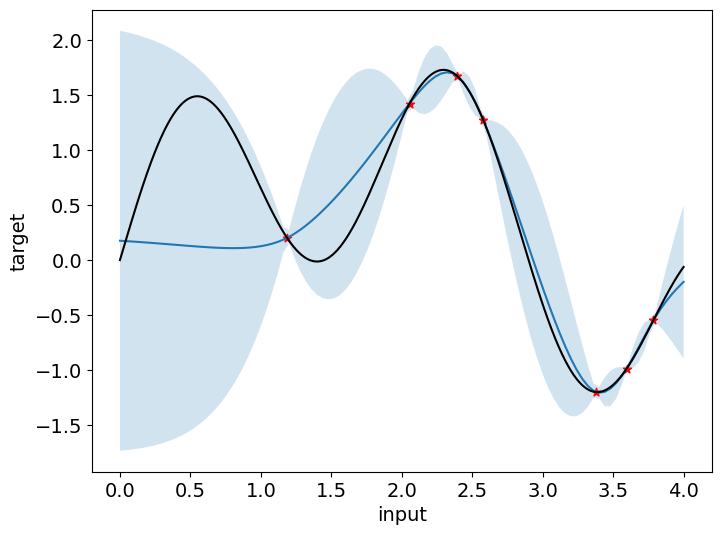

In [6]:
# Helper function that takes input data, kernel+likelihood specifications, and plotting options --> return trained model
def get_trained_GP(X, Y, kernel_type, noise_free=False, plot_1d=False, plot_bounds=None):
    """
    This function is used to train a GP model based on the type of kernel that you select.
    This function will be used in modules 1,2,and 3. Save this function for later
    If you delete this cell accidentally, let us know!

    -----------
    Arg:
    X: Features/ Input vector -- torch tensor 
    Y: Mapping/ Target variable vector -- torch tensor
    kernel_type: 'RBF'/'Linear'/'Periodic'/'Matern05'/'Matern15'/'Matern25' select one -- str
    noise_free: True or False (are observations noise free?)
    plot_1d: True or False (should we plot or not?)
    plot_bounds: Tuple of lower and upper bounds (xL, xU)

    ----------
    returns:

    model: a GP model object in train mode -- gpytorch
    """  

    # make sure input data is shaped properly (ntrain by ninputs)
    if X.ndim < 2:
      print("Need to specify as matrix of size ntrain by ninputs")

    # make sure training data has the right dimension
    if Y.ndim == 1:
        Y = Y.unsqueeze(-1)

    # output scaling
    standardize = Standardize(m=Y.shape[-1])
    outcome_transform = standardize

    # select covariance module
    input_dim = X.shape[-1]
    if kernel_type == 'RBF':
        covar_module = ScaleKernel(RBFKernel(ard_num_dims=input_dim))
    elif kernel_type == 'Linear':
        covar_module = ScaleKernel(LinearKernel(ard_num_dims=input_dim))
    elif kernel_type == 'Periodic':
        covar_module = ScaleKernel(PeriodicKernel(ard_num_dims=input_dim))
    elif kernel_type == 'Matern05':
        covar_module = ScaleKernel(MaternKernel(nu=0.5, ard_num_dims=input_dim))
    elif kernel_type == 'Matern15':
        covar_module = ScaleKernel(MaternKernel(nu=1.5, ard_num_dims=input_dim))
    elif kernel_type == 'Matern25':
        covar_module = ScaleKernel(MaternKernel(nu=2.5, ard_num_dims=input_dim))

    # set the likelihood
    if noise_free:
      likelihood = GaussianLikelihood(noise_constraint=Interval(lower_bound=1e-5, upper_bound=1e-3))
    else:
      likelihood = GaussianLikelihood(noise_constraint=Interval(lower_bound=1e-5, upper_bound=100))

    # define the model
    model = SingleTaskGP(train_X=X, train_Y=Y, covar_module=covar_module, likelihood=likelihood, outcome_transform=outcome_transform)

    # call the training procedure
    model.outcome_transform.eval()
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)

    # put in eval mode
    model.eval()

    # plot if specified 
    if plot_1d:
      if input_dim == 1:
        if plot_bounds is None:
          print("Plot bounds not specified!")
        else:
          x_list = torch.linspace(plot_bounds[0], plot_bounds[1], 101)
          preds = model.posterior(x_list.unsqueeze(-1))
          mean = preds.mean.squeeze()
          var = preds.variance.squeeze()
          lcb = mean - 2*torch.sqrt(var)
          ucb = mean + 2*torch.sqrt(var)
          plt.figure(figsize=(8,6))
          plt.plot(x_list, mean.detach().numpy())
          plt.fill_between(x_list, lcb.detach().numpy(), ucb.detach().numpy(), alpha=0.2)
          plt.scatter(X.detach().numpy(), Y.detach().numpy(), color ='red', marker ='*')
          plt.xlabel('input')
          plt.ylabel('target')
      else:
        print("Too many input dimensions to plot!")

    # return the trained model
    return model

# write a simple 1d function [feel free to modify]
f = lambda x: torch.sin(x) + torch.sin((10.0 / 3.0) * x)

# define input range
x_min, x_max = 0.0, 4.0

# generate some number of random data points
Ninit = 7
torch.manual_seed(8)
x_train = (x_max-x_min)*torch.rand((Ninit,1)) + x_min
y_train = f(x_train)

# fit model
model = get_trained_GP(x_train, y_train, 'Matern15', noise_free=True, plot_1d=True, plot_bounds=(x_min, x_max))
xlist = torch.linspace(x_min, x_max, 1001)
plt.plot(xlist, f(xlist), '-k');

## Expected Improvement (EI)

As we discussed in the slides, one of the most popular acquisition functions is expected improvement (EI). Given the GP model that we have trained and the best current value from the training data (often called the incumbent), we can directly build EI in BoTorch.

In [7]:
# construct torch acquisition function
best_value = y_train.max()
ei = ExpectedImprovement(model=model, best_f=best_value, maximize=True)

I can now treat ```ei``` as any other torch object, meaning I can evaluate and plot it and I can evaluate its derivatives using torch. Note that you can read more about torch's autograd capabilities [here](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html), with the main difference being you need to specify if the tensor input requires gradients to be computed or not (using the ```requires_grad``` option, which is false by default). You also need to call the ```.backward()``` method on the expression once you have generated it. Note that BoTorch requires you to feed the input as a tensor of size $b \times q \times d$ where $b$ is the batch number (repeat samples), $q$ is the number of parallel samples (will always be 1 for us), and $d$ is the number of dimensions.  

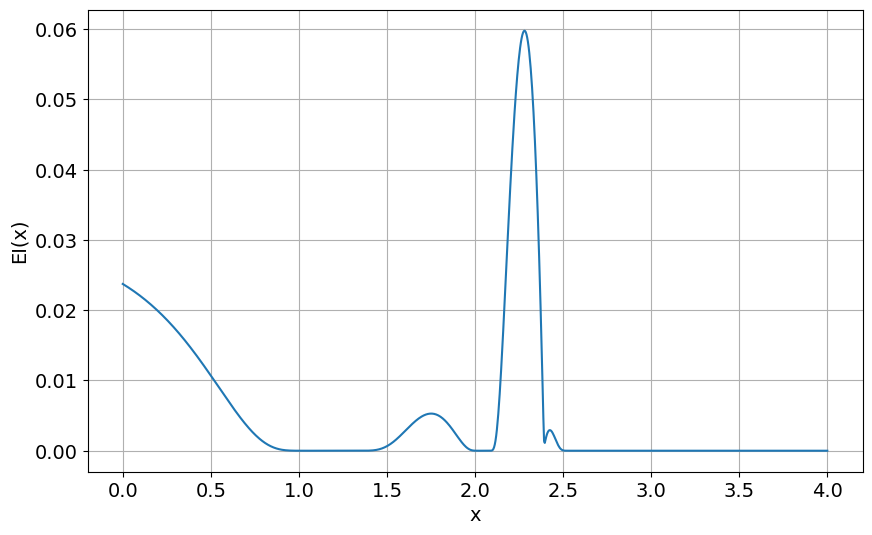

In [8]:
# generate grid of points (b x d)
X = torch.linspace(x_min, x_max, 1001).reshape((1001,1))
# be sure to extend along middle dimension (b x q x d)
X = X.unsqueeze(1)
# evaluate acquisition
with torch.no_grad():
  EI_Vals = ei(X)
# plot the EI values
plt.figure(figsize=(10,6))
plt.plot(X.squeeze(1), EI_Vals)
plt.xlabel('x')
plt.ylabel('EI(x)')
plt.grid()

### Exercise

Compute the gradient of the EI acqusition function at $x=0$. See if it matches the plot of the function $\text{EI}(x)$ above. 

In [9]:
# Exercise code here


Answer:

tensor([-0.0153])


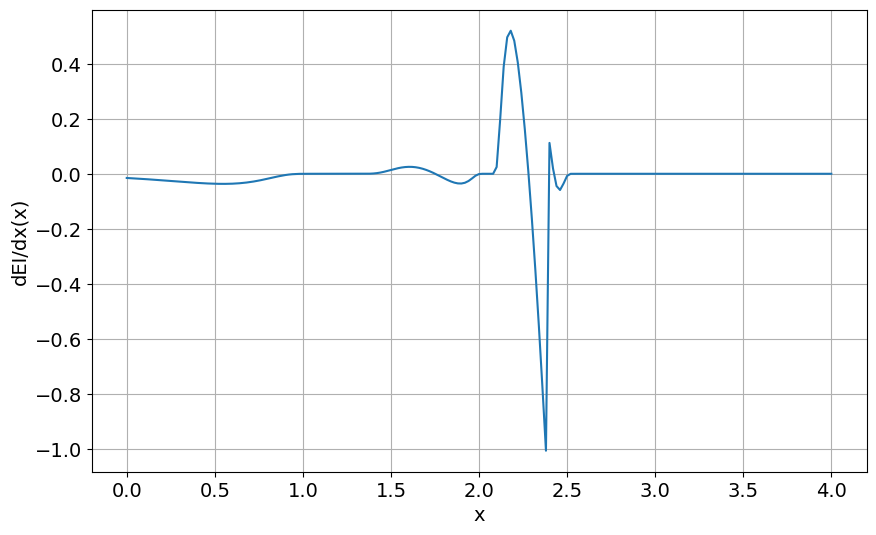

In [10]:
#@title
# Code is similar to above, but now we need to track gradients and backprop
x = torch.tensor([0.0], requires_grad=True)
x_unsqueeze = x.unsqueeze(1)
ei_val = ei(x_unsqueeze)
ei_val.backward()
ei_grad = x.grad
print(ei_grad)

# We can repeat over many values
x_list = np.linspace(x_min, x_max, 201)
ei_grad_list = np.zeros(201)
for i in range(201):
  x = torch.tensor([x_list[i]], dtype=torch.float32, requires_grad=True)
  x_unsqueeze = x.unsqueeze(-1)
  ei_val = ei(x_unsqueeze)
  ei_val.backward()
  ei_grad = x.grad
  ei_grad_list[i] = ei_grad.detach().numpy()
plt.figure(figsize=(10,6))
plt.plot(x_list, ei_grad_list)
plt.xlabel('x')
plt.ylabel('dEI/dx(x)')
plt.grid()

## Upper Confidence Bound (UCB)

The upper confidence bound acquisition function has the following simple form in terms of the posterior GP mean and standard devation:

$$
\mu_n(x) + \sqrt{\beta_{n+1}} \sigma_n(x)
$$

Although not necessarily guaranted to provide one-step optimal performance, there have been a lot of works that study the theoretical properties of UCB (including convergence).  

### Exercise 1

Using the previous code, along with the list of acquisition functions [here](https://botorch.org/api/acquisition.html#expectedimprovement), implement the upper confidence bound acquisition function for maximizing the unknown function using a confidence bound parameter value of 2 ($\beta_{n+1}=4$). Plot its value along its min and max values. 

In [11]:
# Exercise code here


Answer:

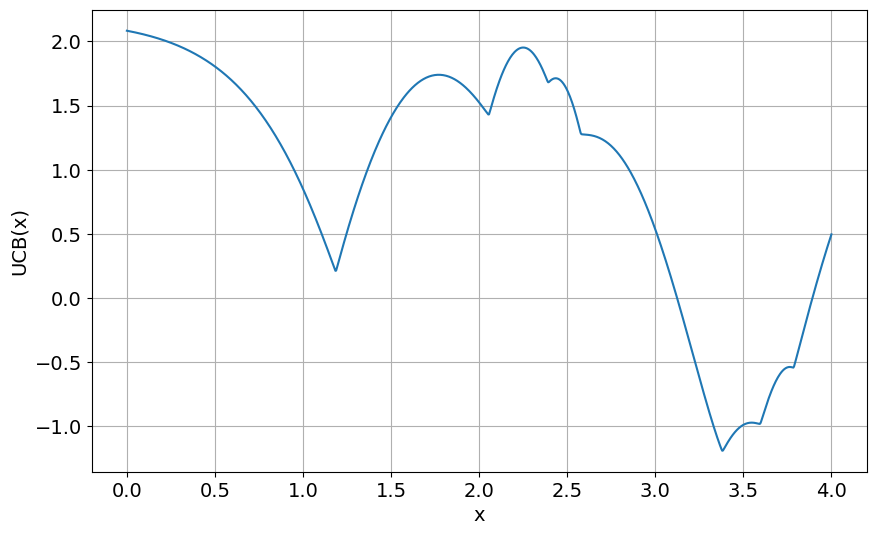

In [12]:
#@title
# construct torch acquisition function
ucb = UpperConfidenceBound(model=model, beta=4, maximize=True)
# generate grid of points (b x d)
X = torch.linspace(x_min, x_max, 1001).reshape((1001,1))
# be sure to extend along middle dimension (b x q x d)
X = X.unsqueeze(1)
# evaluate acquisition
with torch.no_grad():
  UCB_Vals = ucb(X)
# plot the UCB values
plt.figure(figsize=(10,6))
plt.plot(X.squeeze(1), UCB_Vals)
plt.xlabel('x')
plt.ylabel('UCB(x)')
plt.grid()

### Exercise 2

Find the points that EI and UCB would recommend that you sample next. You can simply find these point that yields the largest EI and UCB values out of your grid of points (this is approximate but is fine for 1d). Do they recommend a similar point?

In [13]:
# Exercise code here


Answer:

In [14]:
#@title
# NOTE: This code will only work if you did not overwrite any of the variable names (+ used same grid size for both EI and UCB)
x_next_ei = X[torch.argmax(EI_Vals)]
print(f"Next recommended point by EI: {x_next_ei.detach().numpy().squeeze()}")
x_next_ucb = X[torch.argmax(UCB_Vals)]
print(f"Next recommended point by UCB: {x_next_ucb.detach().numpy().squeeze()}")

Next recommended point by EI: 2.2799999713897705
Next recommended point by UCB: 0.0


# Maximizing the Acqusition Function

As mentioned in the slides, it is common to use a combination of multi-start and local gradient-based methods to attempt to globally optimize the acquisition function in practice. We have implemented a helper function below that allows you to do this straightforwardly on any acquisition function defined by a BoTorch class. Note that you can modify the default values for number of restarts and initial number of raw samples, if you like.

In [15]:
def optimize_my_acqf(acq, xL, xU, num_restarts=10, raw_samples=1000):
    """
    This function is used to select an acquisition function and select the best point based on the information.
    This function will be used in modules 2 and 3. Save this function for later
    If you delete this cell accidentally, let us know!

    -----------
    Args:
    acq: the specified acquisition function -- botorch class
    xL: Lower limit of X (input variables) -- torch tensor (1d)
    xU: Upper limit of Y (output variables) -- torch tensor (1d)
    num_restarts: Number of multi-starts to perform -- integer
    raw_samples: Number of random initial samples to use to generate multi-start candidates

    ----------
    returns:

    new_point : next point (x) to sample to obtain f(x) -- torch tensor    
    acq_val : the value of the acquisition function at this point -- torch tensor    
    """  

    # write out bounds in botorch notation
    nx = xL.shape[0]
    bounds = torch.tensor([(xL[j], xU[j]) for j in range(nx)]).T

    # run the optimization routine and extract the required values
    try:
      new_point, acq_value_list = optimize_acqf(acq_function=acq, bounds=bounds, q=1, num_restarts=num_restarts, raw_samples=raw_samples, options={})
      acq_val = acq_value_list.numpy()
      
    except:
      print('Optimizing the acqusition failed, so taking single random point')
      new_point = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(1, nx)
      acq_val = float('nan')

    return new_point, acq_val

Let's see if it can help us solve the previous problem effectively. 

In [16]:
# let's write out two acquisition functions
best_value = y_train.max()
ei = ExpectedImprovement(model=model, best_f=best_value, maximize=True)
ucb = UpperConfidenceBound(model=model, beta=4, maximize=True)

# stack them in a list
name_list = ['ei', 'ucb']
acq_list = [ei, ucb]

# loop over them
for (i,acq) in enumerate(acq_list):
  new_x, acq_val = optimize_my_acqf(acq, torch.tensor([x_min]), torch.tensor([x_max]))
  print(f"The recommended point for {name_list[i]} is {new_x.detach().numpy().squeeze()}")
  print(f"The acquisition function value for {name_list[i]} is {acq_val}")

The recommended point for ei is 2.2809388637542725
The acquisition function value for ei is 0.0597916916012764
The recommended point for ucb is 0.0
The acquisition function value for ucb is 2.0839507579803467


# Some Additional Reading

## Parallel Evaluation

You may have noticed the $q$ parameter in the previous section -- this corresponds to the number of samples we want to select in parallel. We have focused on $q=1$, which corresponds to a single sample being taken at each point; however, this can be set to larger values if desired. This can be especially useful if you have access to parallel computing and/or experimentation facilities. These acquisition functions cannot be computed analtyically. A good overview on ways to approximate these type of acquisition functions is given in ([Wilson et al. 2017](https://arxiv.org/pdf/1712.00424.pdf)).

Please refer to [this page](https://botorch.org/docs/acquisition) for details on how to compute parallel acquisition functions. I plan to upload more material on this at a future date. 



## Entropy Search

Recall in Thompson Sampling, we draw function realizations as the acquisition function. Instead of drawing single samples, the Entropy Search (ES) acquisition considers the entire posterior distribution $p(x|\mathcal{D})$ and attempts to find query points that reduce the uncertainty of the optimal solution ([Villemonteix et al. 2007](https://arxiv.org/pdf/cs/0611143.pdf)), shown here:

$$ \alpha_{ES}(x) = H(p(x^*)) - \mathbb{E}_{f(x)}[H(p(x^*|f(x))] $$

Here, the uncertainty in the true location of the optimizer, $ x^* $, is expressed as the differential entropy $H$. The first term, $H(p(x^*))$ represents the differential entropy on the posterior deistrubtion of $x^*$. The second expectation term represents the differential entropy of $x^*$ given that a new pair of data $x$ and $f(x)$ is observed. Similar to KG, the ES acquisition is a policy that focuses on maximizing information gain from the posterior distribution (as opposed to EI, which maximizes information gain from data).

However, unlike KG, there is no efficient method for calculating ES because: there is no closed-form equation for the first term in ES; furthermore, we must take a large number of samples to approximate the second term. The resulting function is incredibly complex to optimize. Although approximations for ES have been developed through discretation of the design space ([Hennig and Schuler 2012](https://jmlr.csail.mit.edu/papers/volume13/hennig12a/hennig12a.pdf)), its calculation is still $\mathcal{O}(M^4)$, where $M$ is the number is discretation points.

More recently, an alternate method known as Predictive Entropy Search (PES) ([Hernández-Lobato et al. 2014](https://proceedings.neurips.cc/paper/2014/hash/069d3bb002acd8d7dd095917f9efe4cb-Abstract.html)) have been developed due to the inefficient optimization inherent in ES. PES uses the symmetrical property of mutual information gain: the reduction in entropy of the optimizer $x^*$ due to observing $f(x)$ is equal to the mutual information between them ([Frazier 2018](https://arxiv.org/pdf/1807.02811.pdf)). 

$$ \alpha_{ES}(x) = H(p(f(x))) - \mathbb{E}_{x^*}[H(p(f(x)|x^*)] $$

Although the second term must still be approximated, the first term has a closed form and the overall optimization has similar complexity to the EI acquisition. An implementation of the *Max Value Entropy Search* (MES), which is a further simplification of PES (by quantifying information only the maximum function value) can be found from BoTorch [here](https://botorch.org/tutorials/max_value_entropy).

